In [ ]:
%pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install torchaudio

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install spafe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 3.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 9.0 MB/s eta 0:00:00


In [5]:
import librosa
import torchaudio
import numpy as np
from glob import glob
from tqdm import tqdm
import pandas as pd
import shap

In [6]:
def get_label(file_name):
  '''
  Function to retrieve output labels from filenames
  '''
  if 'ROC' in file_name:
    label=0
  elif 'LES' in file_name:
    label=1
  elif 'DC' in file_name:
    label=2
  elif 'PRV' in file_name:
    label=3
  elif 'VLD' in file_name:
    label=4
  else:
    raise ValueError('invalid file name')
  return label

In [7]:
#First we obtain the list of all files in the train_clean directory
train_files = glob('drive/MyDrive/24Winter/214A/project_data/train_clean/*.wav')
#Let's sort it so that we're all using the same file list order
#and you can continue processing the features from a given file if it stops
#partway through running
train_files.sort()

train_label=[]

for wav in tqdm(train_files):
  train_label.append(get_label(wav))

#Now we obtain the list of all files in the test_clean directory
test_clean_files = glob('drive/MyDrive/24Winter/214A/project_data/test_clean/*.wav')

#Similar to above, we sort the files
test_clean_files.sort()

test_clean_label=[]

for wav in tqdm(test_clean_files):
  test_clean_label.append(get_label(wav))

#Finally we obtain the list of all files in the test_noisy directory
test_noisy_files = glob('drive/MyDrive/24Winter/214A/project_data/test_noisy/*.wav')

#Similar to above, we sort the files
test_noisy_files.sort()

test_noisy_label=[]

for wav in tqdm(test_noisy_files):
  test_noisy_label.append(get_label(wav))

y_train=np.stack(train_label)
y_test_clean=np.stack(test_clean_label)
y_test_noisy=np.stack(test_noisy_label)

100%|██████████| 347/347 [00:00<00:00, 726984.76it/s]


##6. combine pipeline I + II (selected feature)

Train Clean Acc = 1.0

Test Clean Acc = 0.814317673378076

Test Noisy Acc = 0.7521613832853026

In [ ]:
# train_cg_feat_df.to_csv('drive/MyDrive/24Winter/214A/features/combined_cg_train.csv', )
# test_clean_cg_feat_df.to_csv('drive/MyDrive/24Winter/214A/features/combined_cg_test_clean.csv')
# test_noisy_cg_feat_df.to_csv('drive/MyDrive/24Winter/214A/features/combined_cg_test_noisy.csv')

In [8]:
train_cg_feat_df = pd.read_csv('drive/MyDrive/24Winter/214A/features/combined_cg_train.csv', index_col = 0)
test_clean_cg_feat_df = pd.read_csv('drive/MyDrive/24Winter/214A/features/combined_cg_test_clean.csv', index_col = 0)
test_noisy_cg_feat_df = pd.read_csv('drive/MyDrive/24Winter/214A/features/combined_cg_test_noisy.csv', index_col = 0)

In [12]:
import xgboost

n_gtcc = 13
n_mfcc = 13
n_chroma = 12

feat_names = ['gtcc_' + str(n) for n in range(n_gtcc)]
chroma_feat_names = ['tempo'] + ['mfcc_' + str(n) for n in range(n_mfcc)] + ['chroma_' + str(n) for n in range(n_chroma)]
feat_cg_names = feat_names + chroma_feat_names

gtcc_num = [0,2,3,1,12,9,5,7,11,8,10,6,4]
chroma_num = [11,4,3,2,1,6]
mfcc_num = [2,9,7,1,8,5,4,3]

cg_select = ['gtcc_' + str(n) for n in gtcc_num] + ['chroma_' + str(n) for n in chroma_num] + ['mfcc_' + str(n) for n in mfcc_num]
# combined_cg_model = xgboost.XGBClassifier()
combined_cg_model = xgboost.XGBClassifier(
    max_depth=25,
    n_estimators=151,
    learning_rate=0.655,
    gamma=0.1,
    reg_alpha=0.09,
    reg_lambda=0.243,
    subsample=0.41,
    colsample_bytree=0.8
)
combined_cg_model.fit(train_cg_feat_df[cg_select],y_train)

print("Train Clean Acc =", np.sum(y_train==combined_cg_model.predict(train_cg_feat_df[cg_select]))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==combined_cg_model.predict(test_clean_cg_feat_df[cg_select]))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==combined_cg_model.predict(test_noisy_cg_feat_df[cg_select]))/len(y_test_noisy))

Train Clean Acc = 1.0
Test Clean Acc = 0.814317673378076
Test Noisy Acc = 0.7521613832853026


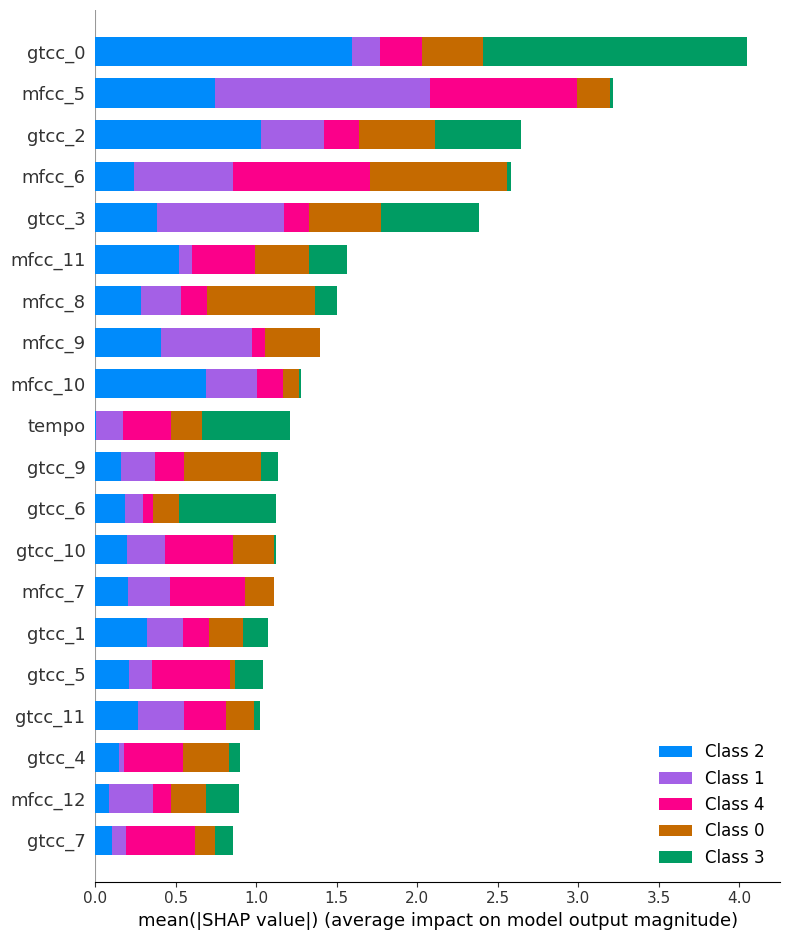

In [13]:
combined_cg_explainer = shap.TreeExplainer(combined_cg_model)
combined_cg_shap_values = combined_cg_explainer.shap_values(train_cg_feat_df[cg_select])

combined_cg_shap_values_list = [combined_cg_shap_values[:, :, i] for i in range(combined_cg_shap_values.shape[2])]

shap.summary_plot(combined_cg_shap_values_list, features=train_cg_feat_df[cg_select], feature_names=feat_cg_names, plot_type="bar")

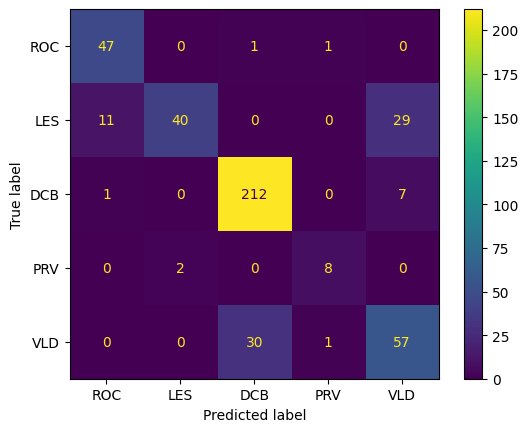

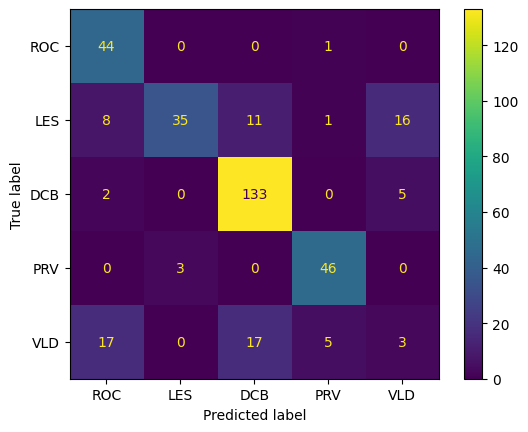

In [14]:
from sklearn import metrics
import matplotlib.pyplot as plt

combined_cg_confusion_matrix_clean = metrics.confusion_matrix(y_test_clean, combined_cg_model.predict(test_clean_cg_feat_df[cg_select]))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = combined_cg_confusion_matrix_clean, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()

combined_cg_confusion_matrix_noisy = metrics.confusion_matrix(y_test_noisy, combined_cg_model.predict(test_noisy_cg_feat_df[cg_select]))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = combined_cg_confusion_matrix_noisy, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()